In [1]:
# Basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

# Trying out a bunch of things. 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder

#Maths 
from numpy import absolute
from numpy import mean
from numpy import std

#Visalization
from matplotlib import pyplot as plt
import seaborn as sns

# Clean up options
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.precision", 2)

In [2]:
# Read All IPL Data
deliveres = pd.read_csv("C:/Users/utkar/OneDrive/Desktop/Analytics/Data/IPL Ball-by-Ball 2008-2020.csv")
matches = pd.read_csv("C:/Users/utkar/OneDrive/Desktop/Analytics/Data/IPL Matches 2008-2020.csv")

# Make a copy
del_df = deliveres.copy()
match_df = matches.copy()

In [3]:
batsman_df = del_df
comb = pd.merge(batsman_df, match_df, on = 'id', how='left')

In [4]:
comb.columns

Index(['id', 'inning', 'over', 'ball', 'batsman', 'non_striker', 'bowler',
       'batsman_runs', 'extra_runs', 'total_runs', 'non_boundary', 'is_wicket',
       'dismissal_kind', 'player_dismissed', 'fielder', 'extras_type',
       'batting_team', 'bowling_team', 'Unnamed: 18', 'city', 'date',
       'player_of_match', 'venue', 'neutral_venue', 'team1', 'team2',
       'toss_winner', 'toss_decision', 'winner', 'result', 'result_margin',
       'eliminator', 'method', 'umpire1', 'umpire2'],
      dtype='object')

In [5]:
# Drop Unneeded columns
comb = comb.drop(["non_striker", "extra_runs", "total_runs" , 'batting_team', 'non_boundary' , 'dismissal_kind' , 'fielder' , 'extras_type' , 'city' , 'date' , 'player_of_match' , 'neutral_venue' , 'team1' , 'team2' , 'toss_winner' , 'toss_decision' , 'winner' , 'result' , 'result_margin' , 'eliminator' , 'method' , 'umpire1' , 'umpire2'], axis=1)

In [6]:
# Runs Scored per inning and balls faced per inning
tmpRuns = pd.DataFrame(comb.groupby(['id', 'batsman']).batsman_runs.sum()).rename(columns = {'batsman_runs' : 'totalRuns'}).reset_index()
tmpBalls = pd.DataFrame(comb.groupby(['id', 'batsman']).batsman_runs.count()).rename(columns = {'batsman_runs' : 'totalBalls'}).reset_index()

In [7]:
# Shows up sometimes. Pesky unneeded column
comb = comb.loc[:, ~comb.columns.str.contains('^Unnamed')]

In [8]:
# Merge back to original dataframe
comb = pd.merge(comb, tmpRuns, how = 'left' , left_on = ['id','batsman'], right_on = ['id','batsman'])
comb = pd.merge(comb, tmpBalls, how = 'left' , left_on = ['id','batsman'], right_on = ['id','batsman']).reset_index(drop=True)

OversLeftAtEntry = pd.DataFrame(20 - comb.groupby(['id' , 'batsman']).over.min()).rename(columns = {'over' : 'oversLeft'}).reset_index()

comb = comb.drop(['over' , 'ball' , 'batsman_runs', 'player_dismissed', 'bowler' , 'is_wicket'] , axis=1)
comb = comb.drop_duplicates().reset_index(drop=True)

comb = pd.merge(comb, OversLeftAtEntry, how = 'left' , left_on = ['id','batsman'], right_on = ['id','batsman'])

In [9]:
# Calculate rolling average per batsman from the past 2 innings and merge it back to original dataframe/
comb['index_col'] = comb.index

AvgRuns = pd.DataFrame(comb.groupby(['batsman'])['totalRuns'].rolling(5, min_periods =1).mean()).reset_index().rename(columns = {'level_1' : 'index'})
AvgRuns.columns = ['batsman' , 'index_col' , 'RollingAvg']

comb = comb.merge(AvgRuns[['index_col' , 'RollingAvg']] , on='index_col')
comb = comb.drop(['index_col'], axis=1)

# Remove Current row's Score from RollingAverage and mean aver reamining 4 values 
comb['RollingAvg'] = comb.apply(lambda x: ((x['RollingAvg'] * 5 ) - x['totalRuns']) / 4 , axis=1)

In [10]:
# Some more columns needed for predictions
comb['matchesAgainstOpposition'] = comb.groupby(['batsman' , 'bowling_team']).id.cumcount() + 1
comb['matchesAtVenue'] = comb.groupby(['batsman' , 'venue']).id.cumcount() + 1

comb['runsAgainstOppostion'] = comb.groupby(['batsman' , 'bowling_team']).totalRuns.cumsum()
comb['runsAtVenue'] = comb.groupby(['batsman' , 'venue']).totalRuns.cumsum()

comb['AvgAgainstOpposition'] = comb.apply(lambda x: x['runsAgainstOppostion'] / x['matchesAgainstOpposition'] , axis=1)
comb['AvgAtVenue'] = comb.apply(lambda x: x['runsAtVenue'] / x['matchesAtVenue'] , axis=1)

# Run Bucket 
# 0-24  ----> 1
# 25-49 ----> 2
# 50-74 ----> 3
# 75-99 ----> 4
# 100+  ----> 5
comb['RunBucket'] = comb.apply(lambda x: (x['totalRuns'] // 25) + 1, axis=1)
comb['RunBucket'] = comb['RunBucket'].apply(lambda x: 5 if x>=5 else x)

In [11]:
# Encode batsman name. Useful for tracking. Adds little value to predictions
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
comb['batsman_cat'] = labelencoder.fit_transform(comb['batsman'])

In [12]:
comb.head(2)

,id,inning,batsman,bowling_team,venue,totalRuns,totalBalls,oversLeft,RollingAvg,matchesAgainstOpposition,matchesAtVenue,runsAgainstOppostion,runsAtVenue,AvgAgainstOpposition,AvgAtVenue,RunBucket,batsman_cat
0,335982,1,RT Ponting,Royal Challengers Bangalore,M Chinnaswamy Stadium,20,20,15,20.0,1,1,20,20,20.0,20.0,1,396
1,335982,1,BB McCullum,Royal Challengers Bangalore,M Chinnaswamy Stadium,158,77,20,158.0,1,1,158,158,158.0,158.0,5,77


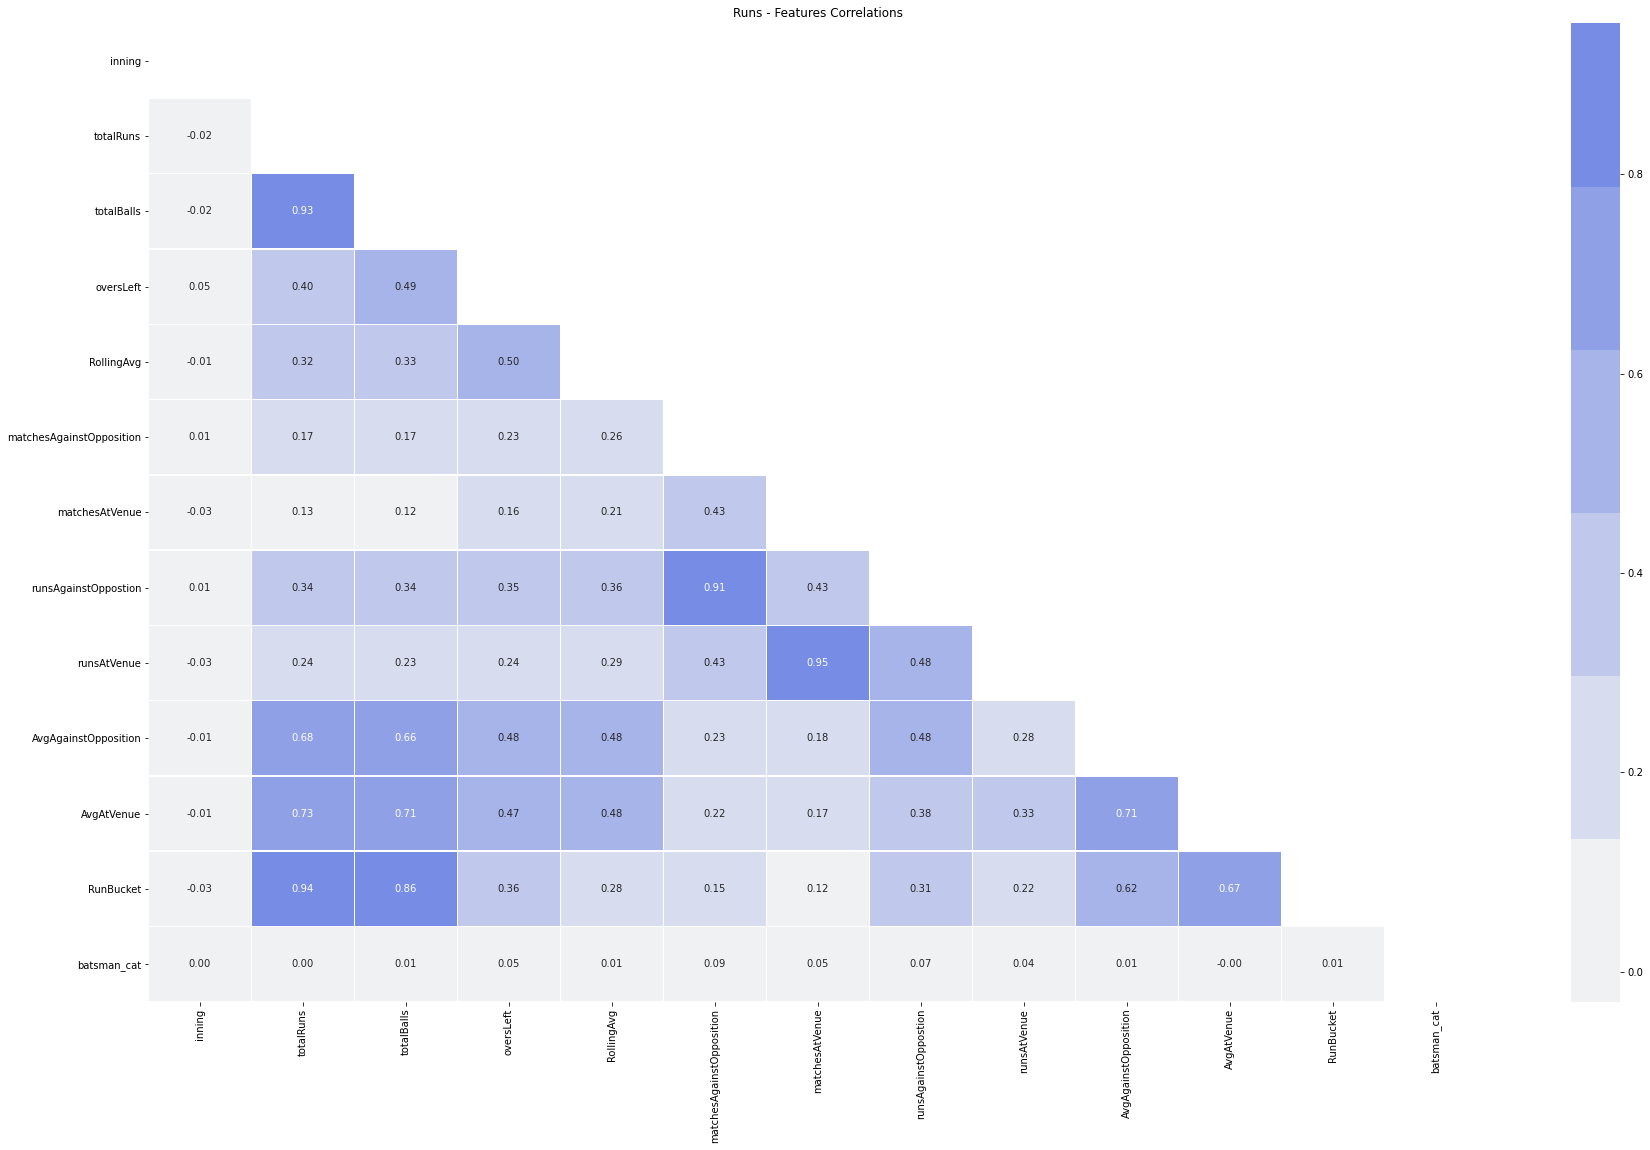

In [13]:
# Plot a correlation Heat Map 
fig, ax = plt.subplots(figsize=(30, 18))
corr = comb.drop(labels = ['id'] , axis=1).corr()

myMask = np.zeros_like(corr)
myMask[np.triu_indices_from(myMask)] = True

colormap = sns.light_palette((260, 75, 60), input="husl")

sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=myMask)
plt.title('Runs - Features Correlations')

plt.show()

### Predicting Batsman's score based on above metrics

In [14]:
# Choosing Features 
x = comb[['oversLeft' , 'RollingAvg' , 'AvgAgainstOpposition' , 'AvgAtVenue' , 'batsman_cat']]

# We need prediction for Total Runs, always. So this is fixed 
y = comb['totalRuns'].values

# Split the data into test/train - 70/30 
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = 0.3 , random_state = 42)

In [15]:
x_test.head(3)

,oversLeft,RollingAvg,AvgAgainstOpposition,AvgAtVenue,batsman_cat
8496,13,23.75,10.4,13.00,460
4046,19,23.75,29.0,31.89,379
8296,10,21.25,28.0,11.50,115


In [16]:
# Linear Regressor 
linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)

print("Accuracy on training data  - " + str(linear_regressor.score(x_train, y_train) * 100) + "%")
y_pred = linear_regressor.predict(x_test)
print("Accuracy on test data  - " + str(linear_regressor.score(x_test, y_test) * 100) + "%")
y_pred = np.rint(y_pred)
print("Mean Absolute Error - " + str(mean_absolute_error(y_test, y_pred)))

Accuracy on training data  - 61.37175466333914%
Accuracy on test data  - 56.61834797983132%
Mean Absolute Error - 8.991230474102494


In [17]:
# Poisson Regressor 
# debug this - not looking correct 
poisson_regressor = PoissonRegressor()
poisson_regressor.fit(x_train, y_train)

print("Accuracy on training data  - " + str(poisson_regressor.score(x_train, y_train) * 100) + "%")
y_pred = poisson_regressor.predict(x_test)
print("Accuracy on test data  - " + str(poisson_regressor.score(x_test, y_test) * 100) + "%")
y_pred = np.rint(y_pred)
print("Mean Absolute Error - " + str(mean_absolute_error(y_test, y_pred)))

Accuracy on training data  - 51.40576374840631%
Accuracy on test data  - 48.65098480099954%
Mean Absolute Error - 10.747053987393807


In [18]:
# Random Forest Regressor
rdf_regressor = RandomForestRegressor(n_estimators=100,max_features=None)
rdf_regressor.fit(x_train,y_train)

print("Accuracy on training data  - " + str(rdf_regressor.score(x_train, y_train) * 100) + "%")
y_pred = rdf_regressor.predict(x_test)
print("Accuracy on test data  - " + str(rdf_regressor.score(x_test, y_test) * 100) + "%")
y_pred = np.rint(y_pred)
print("Mean Absolute Error - " + str(mean_absolute_error(y_test, y_pred)))

Accuracy on training data  - 94.68470271407858%
Accuracy on test data  - 57.280271556268794%
Mean Absolute Error - 8.206083858591395


In [19]:
# GaussianNB
nb_model=GaussianNB()
nb_model.fit(x_train,y_train)

print("Accuracy on training data  - " + str(nb_model.score(x_train, y_train) * 100) + "%")
y_pred = nb_model.predict(x_test)
print("Accuracy on test data  - " + str(nb_model.score(x_test, y_test) * 100) + "%")
y_pred = np.rint(y_pred)
print("Mean Absolute Error - " + str(mean_absolute_error(y_test, y_pred)))

Accuracy on training data  - 9.561846587571948%
Accuracy on test data  - 9.016168813373527%
Mean Absolute Error - 16.021375719375172


In [20]:
# Decision Tree
dt_regressor = DecisionTreeRegressor(criterion='mse', splitter='best',
                             max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                             max_features=None, random_state=None,
                             max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             ccp_alpha=0.0)


dt_regressor.fit(x_train,y_train)

print("Accuracy on training data  - " + str(dt_regressor.score(x_train, y_train) * 100) + "%")
y_pred = dt_regressor.predict(x_test)
print("Accuracy on test data  - " + str(dt_regressor.score(x_test, y_test) * 100) + "%")
y_pred = np.rint(y_pred)
print("Mean Absolute Error - " + str(mean_absolute_error(y_test, y_pred)))

Accuracy on training data  - 100.0%
Accuracy on test data  - 22.591980322026085%
Mean Absolute Error - 11.094546451082488


In [21]:
def predict_score(df, oversLeft, RollingAvg, AvgAgainstOpposition, AvgAtVenue, batsman): 
    
    print("OversLeft = " + str(oversLeft))
    print("RollingAvg = " + str(RollingAvg))
    print("AvgAgainstOpposition = " + str(AvgAgainstOpposition))
    print("AvgAtVenue = " + str(AvgAtVenue))
    print("batsman = " + str(comb[comb.batsman_cat == batsman].batsman.unique()[0]))
    print()
    
    test_input = [[ oversLeft, RollingAvg, AvgAgainstOpposition, AvgAtVenue, batsman]]
    
    # print(test_input)
    print ("Linear Regression Prediction - " + str(np.rint(linear_regressor.predict(test_input))))
    print ("Poisson Regression Prediction - " + str(np.rint(poisson_regressor.predict(test_input))))
    print ("Random Forest Regression Prediction - " + str(np.rint(rdf_regressor.predict(test_input))))
    print ("Gaussian Prediction - " + str(np.rint(nb_model.predict(test_input))))
    print ("Decision Tree Regression Prediction - " + str(np.rint(dt_regressor.predict(test_input))))
    
    real = df[(df.batsman_cat == batsman) & (df.oversLeft == oversLeft) & (df.AvgAgainstOpposition == AvgAgainstOpposition)].totalRuns.sum()
    print("Actual Runs Scored - " , str(real))

In [22]:
# Get a Prediction from all algorithms for same data for comparison
predict_score(comb, 16, 41.5, 35.48, 30.62 , 505)

OversLeft = 16
RollingAvg = 41.5
AvgAgainstOpposition = 35.48
AvgAtVenue = 30.62
batsman = V Kohli

Linear Regression Prediction - [32.]
Poisson Regression Prediction - [25.]
Random Forest Regression Prediction - [56.]
Gaussian Prediction - [36.]
Decision Tree Regression Prediction - [50.]
Actual Runs Scored -  50


### Predicting batsman's score range using Classification Algorithms

In [23]:
# Choosing Features 
x = comb[['oversLeft' , 'RollingAvg' , 'AvgAgainstOpposition' , 'AvgAtVenue' , 'batsman_cat']]

# We need prediction for Run Buckets, always. So this is fixed 
y = comb['RunBucket'].values


# Split the data into test/train - 70/30 
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = 0.3 , random_state = 0)

In [24]:
x_test.head(3)

,oversLeft,RollingAvg,AvgAgainstOpposition,AvgAtVenue,batsman_cat
5762,6,10.25,8.4,10.72,179
8179,6,42.75,30.5,13.00,209
4296,20,43.75,42.5,84.00,42


In [25]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(x_train, y_train)
y_pred = logistic_classifier.predict(x_test)

accuracy=accuracy_score(y_test,y_pred) 
precision=precision_score(y_test,y_pred,average='weighted')
recall=recall_score(y_test,y_pred,average='weighted')
f1=f1_score(y_test,y_pred,average='weighted')

print('Accuracy - {}'.format(accuracy))
print('Precision - {}'.format(precision))
print('Recall - {}'.format(recall))
print('F1 - {}'.format(f1))

Accuracy - 0.7040285009591669
Precision - 0.6573514497273577
Recall - 0.7040285009591669
F1 - 0.6744529547282521


In [26]:
RF_classifier = RandomForestClassifier(n_estimators=50)
RF_classifier.fit(x_train,y_train)
y_pred = RF_classifier.predict(x_test)

accuracy=accuracy_score(y_test,y_pred) 
precision=precision_score(y_test,y_pred,average='weighted')
recall=recall_score(y_test,y_pred,average='weighted')
f1=f1_score(y_test,y_pred,average='weighted')

print('Accuracy - {}'.format(accuracy))
print('Precision - {}'.format(precision))
print('Recall - {}'.format(recall))
print('F1 - {}'.format(f1))

Accuracy - 0.7700739928747602
Precision - 0.7609667401821443
Recall - 0.7700739928747602
F1 - 0.7629017370586135


In [27]:
nb_model=GaussianNB()
nb_model.fit(x_train,y_train)
y_pred=nb_model.predict(x_test)

accuracy=accuracy_score(y_test,y_pred) 
precision=precision_score(y_test,y_pred,average='weighted')
recall=recall_score(y_test,y_pred,average='weighted')
f1=f1_score(y_test,y_pred,average='weighted')

print('Accuracy - {}'.format(accuracy))
print('Precision - {}'.format(precision))
print('Recall - {}'.format(recall))
print('F1 - {}'.format(f1))

Accuracy - 0.7338996985475472
Precision - 0.7560044939055391
Recall - 0.7338996985475472
F1 - 0.742212689183939


In [28]:
def predict_score_range(df, oversLeft, RollingAvg, AvgAgainstOpposition, AvgAtVenue, batsman): 
    
    print("OversLeft = " + str(oversLeft))
    print("RollingAvg = " + str(RollingAvg))
    print("AvgAgainstOpposition = " + str(AvgAgainstOpposition))
    print("AvgAtVenue = " + str(AvgAtVenue))
    print("batsman = " + str(comb[comb.batsman_cat == batsman].batsman.unique()[0]))
    print()
    
    test_input = [[ oversLeft, RollingAvg, AvgAgainstOpposition, AvgAtVenue, batsman]]
    
    # print(test_input)
    print ("Logistic Classifier Prediction - " + str(np.rint(logistic_classifier.predict(test_input))))
    print ("Random Forest Classifier Prediction - " + str(np.rint(RF_classifier.predict(test_input))))
    print ("Gaussian Classifier Prediction - " + str(np.rint(nb_model.predict(test_input))))
    
    real = df[(df.batsman_cat == batsman) & (df.oversLeft == oversLeft) & (df.AvgAgainstOpposition == AvgAgainstOpposition)].totalRuns.sum()
    print("Actual Runs Scored - " , str(real))
    print("Actual Runs Scored Bucket - " , str((real // 25) + 1))

In [29]:
predict_score_range(comb, 20, 80.0 , 94, 30.83, 505)

OversLeft = 20
RollingAvg = 80.0
AvgAgainstOpposition = 94
AvgAtVenue = 30.83
batsman = V Kohli

Logistic Classifier Prediction - [1.]
Random Forest Classifier Prediction - [5.]
Gaussian Classifier Prediction - [5.]
Actual Runs Scored -  108
Actual Runs Scored Bucket -  5


### Findings 

* As features, We have taken into account only oversLeft, AverageAtVenue, AverageAgainstOpposition and RollingAverage from last 4 games. batsman_cat (i.e. batsman id) has no impact on the outcome. 
* For Regression Algorithms, Random Forest Regressor seems to work the best with MAE of ~8 runs
* For Classification, Random Forest Classification has a 77% accuracy of predicting 